In [ ]:
import geopandas as gpd
from tqdm import tqdm
import momepy

In [93]:
blgs=gpd.read_parquet('OSM_no_overlap_collapse.parquet')

In [8]:
blgs

,geometry
0,"POLYGON ((4588533.734 5821521.726, 4588570.786..."
1,"POLYGON ((4591889.97 5823105.866, 4591898.467 ..."
2,"POLYGON ((4592002.064 5821961.774, 4592000.684..."
3,"POLYGON ((4592077.946 5822437.286, 4592070.997..."
4,"POLYGON ((4592403.073 5822915.869, 4592383.652..."
...,...
1056443,"POLYGON ((4599145.094 5819669.998, 4599129.491..."
1056444,"POLYGON ((4576136.11 5806949.507, 4576173.534 ..."
1056445,"POLYGON ((4586760.398 5822967.926, 4586762.549..."
1056446,"POLYGON ((4597976.059 5812604.354, 4597984.496..."


In [114]:
check=momepy.CheckTessellationInput(blgs)

Collapsed features  : 0
Split features      : 414
Overlapping features: 0


In [ ]:
blgs.cx[4592061.95209169:4597983.994257349, 5818788.000805501:5823292.416639388].explore()

In [98]:
blgs.geom_type.value_counts()

Polygon               1056131
MultiPolygon               76
GeometryCollection          2
Name: count, dtype: int64

In [10]:
gpd.__version__

'1.0.0-alpha1'

In [99]:
dwithin = {}

for i, poly in tqdm(blgs.geometry.items(), total=len(blgs)):
    hits = blgs.sindex.query(poly, predicate="dwithin", distance=0.5)
    hits = hits[hits != i]
    dwithin[i] = list(hits)

100%|██████████████████████████████| 1056209/1056209 [01:07<00:00, 15753.01it/s]


In [100]:
dwithin

{0: [],
 1: [656831],
 2: [609993],
 3: [],
 4: [],
 5: [],
 6: [105283, 51],
 7: [60, 1046594, 76],
 8: [76, 75],
 9: [],
 10: [],
 11: [],
 12: [],
 13: [376857],
 14: [],
 15: [],
 16: [11830],
 17: [377433, 30982, 196889],
 18: [196889, 377440, 377436, 377534, 377515, 377529, 30983],
 19: [12153, 377508, 377507],
 20: [],
 21: [78881],
 22: [993024],
 23: [597311, 597345],
 24: [],
 25: [906807],
 26: [906814],
 27: [],
 28: [],
 29: [55297, 720190, 638029],
 30: [123, 46, 124, 80],
 31: [815674, 65, 9612, 103, 105489],
 32: [168459, 83, 84, 71, 72, 85, 86, 60],
 33: [1046594, 1046593, 1046592],
 34: [67, 47],
 35: [58939, 78, 59, 77],
 36: [78],
 37: [],
 38: [75, 52, 67],
 39: [77336, 348258],
 40: [77336],
 41: [55, 80],
 42: [74, 55],
 43: [77, 74],
 44: [77346, 105493],
 45: [123, 46, 124, 47],
 46: [123, 45, 124, 30],
 47: [45, 34, 48],
 48: [47, 50, 49],
 49: [48, 50],
 50: [48, 105282, 49],
 51: [105283, 6, 105282],
 52: [53, 38],
 53: [105283, 52],
 54: [],
 55: [42, 41],


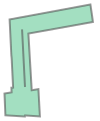

In [101]:
poly

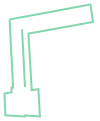

In [102]:
poly.boundary

In [108]:
overlaps={}

for i, poly in tqdm(blgs.geometry.items(), total=len(blgs)):
    hits = blgs.sindex.query(poly, predicate="overlaps")
    hits = hits[hits != i]
    
    if hits.size != 0:
        overlaps[i] = list(hits)

100%|███████████████████████████████| 1056209/1056209 [01:53<00:00, 9321.60it/s]


In [110]:
overlaps

{43725: [49299],
 49299: [43725],
 55114: [580808],
 103209: [228398],
 113429: [816677, 519323],
 228398: [103209],
 519323: [113429],
 577134: [1055092],
 580808: [55114],
 816677: [113429],
 1053845: [1054425],
 1054425: [1053845],
 1054788: [1054790],
 1054790: [1054788],
 1055092: [577134]}

In [117]:
### takes too long to run

overlaps_boundary={}

for i, poly in tqdm(blgs.geometry.items(), total=len(blgs)):
    hits = blgs.boundary.sindex.query(poly.boundary, predicate="overlaps")
    hits = hits[hits != i]
    
    if hits.size != 0:
        overlaps_boundary[i] = list(hits)

  0%|                                  | 89/1056209 [01:41<335:36:33,  1.14s/it]


KeyboardInterrupt: 

In [111]:
blgs.loc[[key for key, array in overlaps.items()]]

,geometry
43725,"POLYGON ((4587225.593 5840203.748, 4587224.783..."
49299,"POLYGON ((4587235.495 5840312.551, 4587250.498..."
55114,"POLYGON ((4603777.47 5817529.023, 4603775.994 ..."
103209,"POLYGON ((4593804.601 5821838.929, 4593804.033..."
113429,"POLYGON ((4599845.981 5819913.247, 4599845.987..."
228398,"POLYGON ((4594023.717 5821781.26, 4593999.549 ..."
519323,"POLYGON ((4599877.608 5819974.63, 4599887.938 ..."
577134,"POLYGON ((4588630.761 5819548.313, 4588632.512..."
580808,"POLYGON ((4603771.326 5817520.022, 4603773.43 ..."
816677,"POLYGON ((4599842.818 5819898.127, 4599783.743..."


In [112]:
blgs.loc[[key for key, array in overlaps.items()]].explore()

### we want buildings within half a metre that do not already overlap (dwithin - overlaps)

In [116]:
buildings_to_snap={k: v for k, v in dwithin.items() if k not in overlaps}

In [118]:
buildings_to_snap

{0: [],
 1: [656831],
 2: [609993],
 3: [],
 4: [],
 5: [],
 6: [105283, 51],
 7: [60, 1046594, 76],
 8: [76, 75],
 9: [],
 10: [],
 11: [],
 12: [],
 13: [376857],
 14: [],
 15: [],
 16: [11830],
 17: [377433, 30982, 196889],
 18: [196889, 377440, 377436, 377534, 377515, 377529, 30983],
 19: [12153, 377508, 377507],
 20: [],
 21: [78881],
 22: [993024],
 23: [597311, 597345],
 24: [],
 25: [906807],
 26: [906814],
 27: [],
 28: [],
 29: [55297, 720190, 638029],
 30: [123, 46, 124, 80],
 31: [815674, 65, 9612, 103, 105489],
 32: [168459, 83, 84, 71, 72, 85, 86, 60],
 33: [1046594, 1046593, 1046592],
 34: [67, 47],
 35: [58939, 78, 59, 77],
 36: [78],
 37: [],
 38: [75, 52, 67],
 39: [77336, 348258],
 40: [77336],
 41: [55, 80],
 42: [74, 55],
 43: [77, 74],
 44: [77346, 105493],
 45: [123, 46, 124, 47],
 46: [123, 45, 124, 30],
 47: [45, 34, 48],
 48: [47, 50, 49],
 49: [48, 50],
 50: [48, 105282, 49],
 51: [105283, 6, 105282],
 52: [53, 38],
 53: [105283, 52],
 54: [],
 55: [42, 41],


In [119]:
blgs.loc[[18, 196889, 377440, 377436, 377534, 377515, 377529, 30983]].explore()

In [ ]:
def _snap(geometry, reference, threshold, segment_length):
    """Snap g1 to g2 within threshold

    Parameters
    ----------
    geometry : shapely.Polygon
        geometry to snap
    reference : shapely.Polygon
        geometry to snap to
    threshold : float
        max distance between vertices to snap
    segment_length : float
        max segment length parameter in segmentize

    Returns
    -------
    shapely.Polygon
        snapped geometry
    """
    # extract the shell and holes from the first geometry
    shell, holes = geometry.exterior, geometry.interiors
    # segmentize the shell and extract coordinates
    coords = shapely.get_coordinates(shapely.segmentize(shell, segment_length))
    # create a point geometry from the coordinates
    points = shapely.points(coords)
    # find the shortest line between the points and the second geometry
    lines = shapely.shortest_line(points, reference)
    # mask the coordinates where the distance is less than the threshold
    distance_mask = shapely.length(lines) < threshold
    # update the coordinates with the snapped coordinates
    coords[distance_mask] = shapely.get_coordinates(lines)[1::2][distance_mask]
    # re-create the polygon with new coordinates and original holes and simplify to remove any extra vertices
    return shapely.simplify(shapely.Polygon(coords, holes=holes), segment_length / 100)